## Example application

The following notebook runs through the application of the pipeline in [Lovell et al. 17](https://arxiv.org/abs/1710.02148v1) to an observed overdensity. Here we look at BOSS1441 from [Cai et al. 17](https://arxiv.org/abs/1609.02913).

First, load some standard modules.

In [1]:
import pandas as pd
import numpy as np
import pickle as pcl

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

Before we start we need to download galaxy catalogues from a cosmological simulation. Here, as in Lovell+17, we use the L-Galaxies SAM results from the nearest snapshot (29). An example query script is shown in the `queries/` folder.

In [2]:
h = 0.673
L = 480.279 / h # box side length

directory = '/lustre/scratch/astro/cl478/protoclusters_data/'
out_directory = 'output/'

redshifts = ['2p25', '2p44']
zees = [float(z.replace('p','.')) for z in redshifts]

Import catalogues, apply z-distortion and h factor correction

In [3]:
from methods import z_distort, factor_h

gals_z2p25 = z_distort(factor_h(pd.read_csv('%shenriques2015a_z%s_sfr_r200.csv'%(directory,redshifts[0]), 
                                skiprows=122, skipfooter=1, engine='python'), h), zees[0], L)

MAMMOTH overdensities

In [4]:
obs = pd.DataFrame()

obs = obs.append({'name': 'BOSS1441 (A)', 'z': 2.32, 'dz': 0.045, 'window': 36, 'R': 5.0, 
                  'delta_g': 11.8, 'delta_g_err': 2.0, 'D': 57.9}, ignore_index=True)

obs = obs.append({'name': 'BOSS1441 (B)', 'z': 2.32, 'dz': 0.045, 'window': 140, 'R': 9.9, 
                  'delta_g': 9.3, 'delta_g_err': 1.6, 'D': 57.9}, ignore_index=True)

obs = obs.append({'name': 'BOSS1542', 'z': 2.25, 'dz': 0.045, 'window': 140, 'R': 9.9, 
                  'delta_g': 15.9, 'delta_g_err': 2.5, 'D': 57.8}, ignore_index=True)

obs = obs.append({'name': 'BOSS1244', 'z': 2.32, 'dz': 0.045, 'window': 140, 'R': 9.9, 
                  'delta_g': 13.3, 'delta_g_err': 2.3, 'D': 57.9}, ignore_index=True)

obs

,D,R,delta_g,delta_g_err,dz,name,window,z
0,57.9,5.0,11.8,2.0,0.045,BOSS1441 (A),36.0,2.32
1,57.9,9.9,9.3,1.6,0.045,BOSS1441 (B),140.0,2.32
2,57.8,9.9,15.9,2.5,0.045,BOSS1542,140.0,2.25
3,57.9,9.9,13.3,2.3,0.045,BOSS1244,140.0,2.32


Choose a candidate

In [5]:
candidate = obs.loc[1]

### Find protocluster coordinates. 

The `get_protoclusters` method returns coordinates, central subhalo Id's and  descendant $M_{200}$ masses for all objects above `cluster_lim`. Here, we choose all group mass objects.

In [6]:
from methods import get_protoclusters

group_coods = get_protoclusters(gals_z2p25, L, cluster_lim=1e3)

### Find limiting completeness and purity

The method `overdensity_cylinder` finds the completeness and purity of the galaxy population surrounding each protocluster, which can be used to define $C_{lim}$ and $P_{lim}$.

In [7]:
from methods import overdensity_cylinder

pc_mask = group_coods['clusters']['z0_central_mcrit200'].values > 1e4

c_p = overdensity_cylinder(gals_z2p25, group_coods['coods'], 
                        R=candidate['R'], dc=candidate['D'] / 2, L=L, pc_stats=True)

In [8]:
clim = np.round(np.percentile(c_p[pc_mask,1], [95,50,5]),3)
plim = np.round(np.percentile(c_p[pc_mask,2], [95,50,5]),3)

print "Clim (5th, median, 95th):", clim, "\nPlim (5th, median, 95th):", plim

dgal = c_p[:,0]
cmass = group_coods['clusters']['z0_central_mcrit200'].values

Clim (5th, median, 95th): [ 1.     1.     0.879] 
Plim (5th, median, 95th): [ 0.573  0.295  0.144]


### Random region stats

Generate `N` random coordinates within the simulation volume.

In [9]:
N = 100000   # number of random regions
coods = pd.DataFrame(np.random.rand(N,3) * L, columns=['zn_x','zn_y','zn_z'])

Calculate overdensity and completeness / purity of each random region.

The `overdensity_cylinder` method takes a dataframe of galaxy properties, and a dataframe of coordinates, and calculates $\delta_{g}$, $C_{lim}$ and $P_{lim}$ for each region.

**Warning:** can take a while for > 10000 regions

In [10]:
stats = overdensity_cylinder(gals_z2p25, coods, R=candidate['R'], dc=candidate['D'] / 2, L=L, pc_stats=True)

Label each random region based on the 5th percentile of the completeness and purity of the protocluster population (`clim` and `plim` calculated previously).

In [29]:
from methods import label

labs, labels = label(stats, clim=clim[2], plim=plim[2])

Bin labels by overdensity

In [30]:
from methods import binit

n = 18
minimum = 10

bins, binLimits, agg, agg_total, fracs = binit(stats, labs, labels, N=n, minimum=minimum)

### Protocluster probability

Calculate protocluster probability for the observational overdensity by finding the ratio of Proto + PartProto regions to Field +  ProtoField regions with that overdensity.

In [54]:
bin_idx = np.where(candidate['delta_g'] > bins)[0].max()

protocluster_labels = labels[:4]

proto_fractions = np.nansum([fracs[l] for l in protocluster_labels], axis=0)

Pdgal = proto_fractions[bin_idx]
Pdgal

0.5

### Descendant mass

Estimate descendant mass from overdensity fit, and quote coefficient of determination.

`dgal_threshold` defines the threshold overdensity above which to fit. This is chosen rather arbitrarily, but should be sufficiently far from the bulk of the overdensity measurements below the cluster mass threshold.

In [69]:
from scipy.optimize import curve_fit
from methods import fit_func, r2

dgal_threshold =np.mean(dgal[cmass > 1e4]) + 1.5

fit_mask = dgal > dgal_threshold

x = np.zeros((dgal.shape[0], 2))  # create feature array

x[:,0] = dgal
x[:,1] = candidate['z']

popt, pcov = curve_fit(fit_func, x[fit_mask,:].T, cmass[fit_mask], maxfev=20000)

R2 = r2(cmass[fit_mask], fit_func(x[fit_mask,:].T, popt[0], popt[1], popt[2], popt[3]))
Mdesc = np.log10(fit_func(np.array([candidate['delta_g'], candidate['z']]), 
                  popt[0], popt[1], popt[2], popt[3]) * 1e10)

print "R2:", round(R2, 3), "\nMdesc:", round(Mdesc, 3)

R2: 0.117 
Mdesc: 14.69


## Plot

Plot of the probability distribution for the labelled random regions, and the fitted overdensity-descendant mass relation

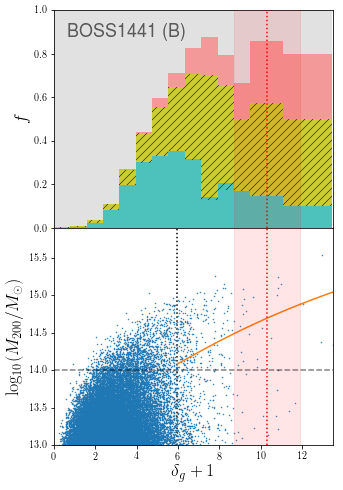

In [70]:
from methods import plotit

fig = plt.figure(figsize=(5,8))

gs = gridspec.GridSpec(2,1)
gs.update(hspace=0, wspace=0)

ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[1,0])

textsize=18

plotit(ax1, stats, axb=None, N=n, clim=clim[2], plim=plim[2], minimum=minimum);

ax2.plot(dgal + 1, np.log10(cmass * 1e10), '.', markersize=1);

ax2.set_ylim(13., 15.9)

for ax in [ax1,ax2]:
    
    ax.vlines(candidate['delta_g'] + 1, ax.get_ylim()[0], ax.get_ylim()[1], linestyle='dotted', color='red', zorder=10)
    
    ax.axvspan(candidate['delta_g'] - candidate['delta_g_err']+1, 
               candidate['delta_g'] + candidate['delta_g_err']+1, 
               color='red', alpha=0.1, zorder=10)


ax2.hlines(14, 0, ax2.get_xlim()[1], linestyle='dashed', alpha=0.5, zorder=10);

## Plot fit

def scale(x):
    return np.log10(x * 1e10)

dgal_range = np.linspace(dgal_threshold, dgal.max(), 100)

ax.vlines(dgal_threshold + 1, ax.get_ylim()[0], ax.get_ylim()[1], linestyle='dotted')

ax.plot(dgal_range+1, scale(fit_func(np.vstack([dgal_range, np.full(len(dgal_range), x[0,1])]),
                             popt[0], popt[1], popt[2], popt[3])))


ax1.set_xticklabels([])
ax2.set_xlabel('$\delta_{g} + 1$', size=textsize)

ax1.set_ylabel('$f$', size=textsize)
ax2.set_ylabel('$\mathrm{log_{10}}(M_{200} / M_{\odot})$', size=textsize)

ax1.text(0.05, 0.88, candidate['name'], transform=ax1.transAxes, size=textsize, alpha=0.6)

for ax in [ax1, ax2]:
        ax.set_xlim(0, max(candidate['delta_g'] + 2, np.max(dgal) + 1))
